# Boundary conditions tutorial 
## (With QC Modifications for Devito Workshop at the 2026 Rice HPC/AI Energy Conference)

<details>
  <summary>Click to expand for more info</summary>

  * This notebook was modified to include QC Tasks for viewing Stencils including by impulse reponses. Modifications by Thomas Cullison at Stanford University

  * The Original Devito notebook can be found on [GitHub](https://github.com/devitocodes/devito/blob/main/examples/userapi/04_boundary_conditions.ipynb)
</details>

This tutorial aims to demonstrate how users can implement various boundary conditions in Devito, building on concepts introduced in previous tutorials. More specifically, this tutorial will use `SubDomain`s to model boundary conditions. `SubDomain`s are the recommended way to model BCs in order to run with MPI and distributed memory parallelism, as they align with Devito's support for distributed NumPy arrays with zero changes needed to the user code.

Over the course of this notebook we will go over the implementation of both free surface boundary conditions and perfectly-matched layers (PMLs) in the context of the first-order acoustic wave equation. This tutorial is based on a simplified version of the method outlined in Liu and Tao's 1997 paper (https://doi.org/10.1121/1.419657).

We will set up our domain with PMLs along the left, right, and bottom edges, and free surface boundaries at the top as shown below.

<img src="https://raw.githubusercontent.com/devitocodes/devito/main/examples/userapi/figures/boundary_conditions.png" style="width: 220px;"/>

Note that whilst in practice we would want the PML tapers to overlap in the corners, this requires additional subdomains. As such, they are omitted for simplicity.

As always, we will begin by specifying some parameters for our `Grid`:

#### **QC Tip:** Enable autoreload for development testing in notebooks

In [1]:
%load_ext autoreload
%autoreload 2

#### **QC Tip:** It's good to make sure the notebook is using the version of Python expected

In [2]:
from sys import executable as mypythonexe
mypythonversion = !{mypythonexe} --version
# print(f'Python EXE Path: {mypythonexe}')
print(f'Python Version:  {mypythonversion[0]}')

Python Version:  Python 3.10.16


In [3]:
# If able to use widgets, then you can easily zoom in/out of SubDomain boundaries
%matplotlib inline
# %matplotlib widget    

shape = (101, 101)
extent = (2000., 2000.)
nbpml = 10  # Number of PMLs on each side

We will need to use subdomains to accommodate the modified equations in the PML regions.

In [4]:
from devito import SubDomain

so = 6  # Space order


class MainDomain(SubDomain):  # Main section with no damping
    name = 'main'

    def __init__(self, pmls, so, grid=None):
        # NOTE: These attributes are used in `define`, and thus must be
        # set up before `super().__init__` is called.
        self.pmls = pmls
        self.so = so
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.pmls, self.pmls),
                y: ('middle', self.so//2, self.pmls)}


class Left(SubDomain):  # Left PML region
    name = 'left'

    def __init__(self, pmls, grid=None):
        self.pmls = pmls
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', self.pmls), y: y}


class Right(SubDomain):  # Right PML region
    name = 'right'

    def __init__(self, pmls, grid=None):
        self.pmls = pmls
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', self.pmls), y: y}


class Base(SubDomain):  # Base PML region
    name = 'base'

    def __init__(self, pmls, grid=None):
        self.pmls = pmls
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.pmls, self.pmls), y: ('right', self.pmls)}


class FreeSurface(SubDomain):  # Free surface region
    name = 'freesurface'

    def __init__(self, pmls, so, grid=None):
        self.pmls = pmls
        self.so = so
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.pmls, self.pmls), y: ('left', self.so//2)}

We create the grid and set up our subdomains:

In [5]:
from devito import Grid

grid = Grid(shape=shape, extent=extent)

main = MainDomain(nbpml, so, grid=grid)
left = Left(nbpml, grid=grid)
right = Right(nbpml, grid=grid)
base = Base(nbpml, grid=grid)
freesurface = FreeSurface(nbpml, so, grid=grid)

x, y = grid.dimensions

We can then begin to specify our problem starting with some parameters.

In [6]:
density = 1.  # 1000kg/m^3
velocity = 4.  # km/s
gamma = 0.0002  # Absorption coefficient

We also need a `TimeFunction` object for each of our wavefields. As particle velocity is a vector, we will choose a `VectorTimeFunction` object to encapsulate it.

In [7]:
from devito import TimeFunction, VectorTimeFunction, NODE

p = TimeFunction(name='p', grid=grid, time_order=1,
                 space_order=so, staggered=NODE)
v = VectorTimeFunction(name='v', grid=grid, time_order=1,
                       space_order=so)

A `VectorTimeFunction` is near identical in function to a standard `TimeFunction`, albeit with a field for each grid dimension. The fields associated with each component can be accessed as follows:

You may have also noticed the keyword `staggered` in the arguments when we created these functions. As one might expect, these are used for specifying where derivatives should be evaluated relative to the grid, as required for implementing formulations such as the first-order acoustic wave equation or P-SV elastic. Passing a function `staggered=NODE` specifies that its derivatives should be evaluated at the node. One can also pass `staggered=x` or `staggered=y` to stagger the grid by half a spacing in those respective directions. Additionally, a tuple of dimensions can be passed to stagger in multiple directions (e.g. `staggered=(x, y)`). `VectorTimeFunction` objects have their associated grids staggered by default.

We will also need to define a field for integrating pressure over time:

In [8]:
p_i = TimeFunction(name='p_i', grid=grid, time_order=1,
                   space_order=1, staggered=NODE)

Next we prepare the source term:

In [9]:
import numpy as np
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts at t=0
tn = 400.  # Simulation length in ms
dt = 1e2*(1. / np.sqrt(2.)) / 60.  # Time step

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.02
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = 1000.

In [10]:
src.coordinates.data

Data([[1000., 1000.]], dtype=float32)

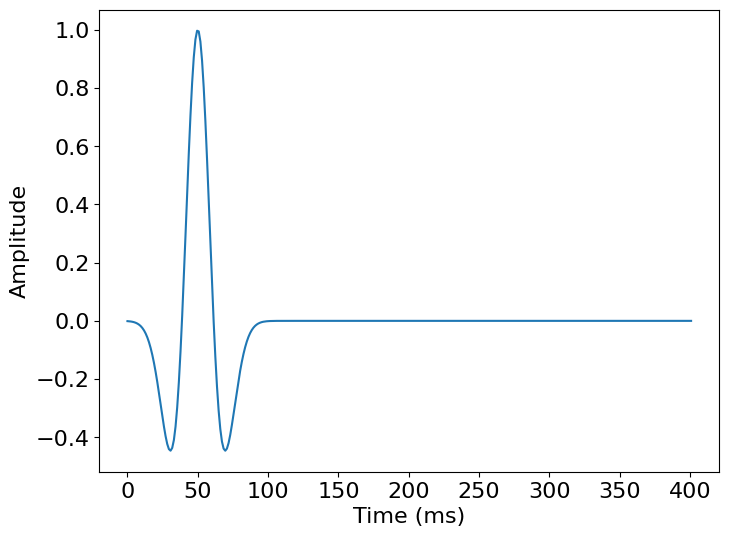

In [11]:
src.show()

For our PMLs, we will need some damping parameter. In this case, we will use a quadratic taper over the absorbing regions on the left and right sides of the domain.

In [12]:
# # Damping parameterisation
d_l = (1-0.1*x)**2  # Left side
d_r = (1-0.1*(grid.shape[0]-1-x))**2  # Right side
d_b = (1-0.1*(grid.shape[1]-1-y))**2  # Base edge

Now for our main domain equations:

In [13]:
from devito import Eq, grad, div

eq_v = Eq(v.forward, v - dt*grad(p)/density,
          subdomain=main)

eq_p = Eq(p.forward, p - dt*velocity**2*density*div(v.forward),
           subdomain=main)

## **QC Task:** "Inject" Impulses into $v_x(x,y)$, and $v_y(x,y)$ Fields

We will place impulses at the center, and at each corner execatly the "half-with" of the spatial sentcil away from the edges.

The plotted values will be the coefficients of $\nabla \cdot \mathbf{v}$. If using interactive plotting, then the plotted values can be examined using the mouse-over feature.

In [14]:
# If able to use widgets, then you can easily zoom in/out of plots
# %matplotlib inline
%matplotlib widget

#### Calculate Corner Indices for Impuluses (uses a utility function)

In [15]:
# QC utility for gettting near-corner points (both indices and coordinates) 
from devito_qc_utils import get_near_corner_points

# Example usage:
icorners, ccorners = get_near_corner_points(grid, so=so)
print("Indices:", icorners)
print("Coordinates:", ccorners)

Indices: [(3, 3), (3, 97), (97, 3), (97, 97)]
Coordinates: [(np.float32(60.0), np.float32(60.0)), (np.float32(60.0), np.float32(1940.0)), (np.float32(1940.0), np.float32(60.0)), (np.float32(1940.0), np.float32(1940.0))]


#### Create Divergence Function and Equation

In [16]:
from devito import Function

div_v = Function(name='div_v', grid=grid, space_order=so)
eq_div = Eq(div_v, div(v.forward))

#### Zero $\mathbf{\vec{v}}$ Data Fields

In [17]:
v[0].data.fill(0)
v[1].data.fill(0)

#### Create **ix** and **iy** Index Lists Including for Center

In [18]:
nx, ny = grid.shape
cix, ciy = nx // 2, ny // 2         # Center indicies
imp_coords = icorners + [(cix,ciy)]
ix, iy = zip(*imp_coords)             # Unzip list of index pairs into separate lists

#### Set Impulses

In [19]:
v[0].data[1,ix,iy] = 1.0
v[1].data[1,ix,iy] = 1.0 

#### Run Operator

In [20]:
from devito import Operator
op_div = Operator([eq_div])

# Apply once
op_div(time=0)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

#### Scale Impulse Responses by $h_x$ or $h_y$ (NOTE: $h_x = h_y$)

In [21]:
hx, hy = grid.spacing
assert hx == hy 
plt_data = hx*np.array(div_v.data) # the impulse will have been scaled by 1/h

#### Plot impulse Responses

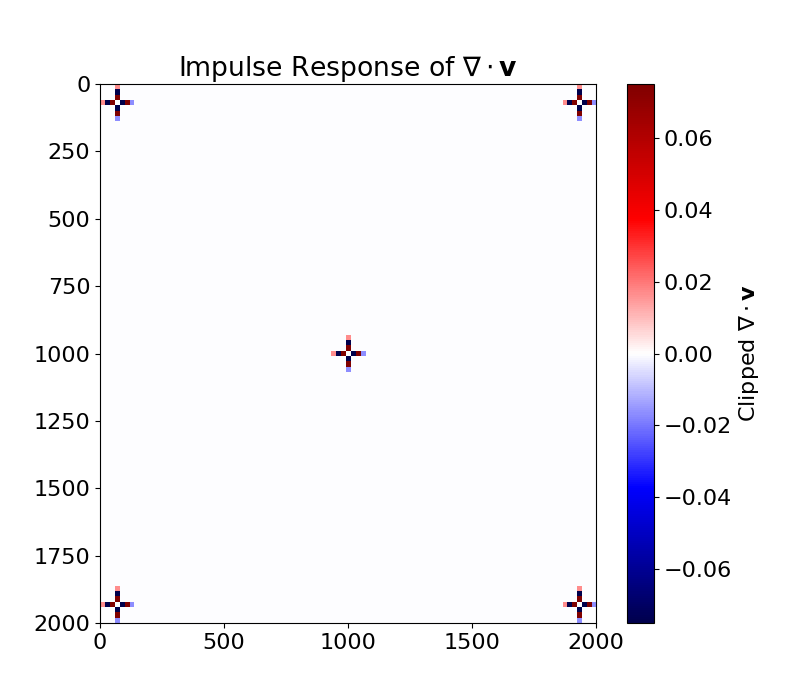

In [22]:
import matplotlib.pyplot as plt

vmax = 0.1*np.abs(plt_data).max() # 0.1 factor is for visability of each stencil coefficient
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(plt_data.T, origin="upper", aspect='auto', cmap='seismic', interpolation='nearest',
               vmin=-vmax, vmax=vmax, extent=[0, grid.extent[0], grid.extent[1], 0])
ax.set_title(r"Impulse Response of $\nabla \cdot \mathbf{v}$")
plt.colorbar(im, ax=ax, label=r"Clipped $\nabla \cdot \mathbf{v}$")

plt.tight_layout
plt.show()

#### Zero Data Fields

In [23]:
# zero fields
v[0].data.fill(0)
v[1].data.fill(0)

## **QC Task:** A DataFrame (table) Can Also Be Constructed for The Coefficients of $\nabla \cdot \mathbf{v}$

This part was trickey for me to figure out. Mutliple iterations with an LLM, and it requires a deeper understanding of SymPy.

In [24]:
import pandas as pd
import sympy as sp

from IPython.display import display as ipy_display
from IPython.display import HTML

In [25]:
hx, hy = grid.spacing
h_df = pd.DataFrame({'h_x': [hx], 'h_y': [hy]})
ipy_display(HTML("<h3>Grid Spacing (h_x and h_y)</h3>"))
display(h_df)

# Expand v_x component (x-derivative)
fd_expr_x = v[0].forward.dx.evaluate
fd_expr_x = sp.expand(fd_expr_x)

terms_x = []
for term in sp.Add.make_args(fd_expr_x):
    coeff, rest = term.as_coeff_Mul()
    funcs = list(rest.atoms(sp.Function))
    if not funcs:
        continue
    func = funcs[0]
    pure_coeff = sp.simplify(coeff * rest / func)
    func_str = str(func)
    # Coefficient includes symbolic 1/h_x
    coeff_symbolic = pure_coeff
    # Evaluate numeric value (divide by hx)
    try:
        coeff_numeric = float(pure_coeff.subs({'h_x': hx}))
    except (TypeError, ValueError):
        coeff_numeric = pure_coeff
    terms_x.append({
        'Function': func_str,
        'Coefficient': coeff_symbolic,
        'Coefficient/h_x': coeff_numeric
    })

# Expand v_y component (y-derivative)
fd_expr_y = v[1].forward.dy.evaluate
fd_expr_y = sp.expand(fd_expr_y)

terms_y = []
for term in sp.Add.make_args(fd_expr_y):
    coeff, rest = term.as_coeff_Mul()
    funcs = list(rest.atoms(sp.Function))
    if not funcs:
        continue
    func = funcs[0]
    pure_coeff = sp.simplify(coeff * rest / func)
    func_str = str(func)
    coeff_symbolic = pure_coeff
    try:
        coeff_numeric = float(pure_coeff.subs({'h_y': hy}))
    except (TypeError, ValueError):
        coeff_numeric = pure_coeff
    terms_y.append({
        'Function': func_str,
        'Coefficient': coeff_symbolic,
        'Coefficient/h_y': coeff_numeric
    })

# Combine and display
coef_x_df = pd.DataFrame(terms_x)
coef_y_df = pd.DataFrame(terms_y)
ipy_display(HTML("<h3>vx Coefficients</h3>"))
display(coef_x_df)
ipy_display(HTML("<h3>vy Coefficients</h3>"))
display(coef_y_df)

,h_x,h_y
0,20.0,20.0


,Function,Coefficient,Coefficient/h_x
0,"v_x(t + dt, x + 3*h_x/2, y)",0.75/h_x,0.037500
1,"v_x(t + dt, x + 7*h_x/2, y)",0.0166666667/h_x,0.000833
2,"v_x(t + dt, x - 3*h_x/2, y)",0.15/h_x,0.007500
3,"v_x(t + dt, x - h_x/2, y)",-0.75/h_x,-0.037500
4,"v_x(t + dt, x - 5*h_x/2, y)",-0.0166666667/h_x,-0.000833
5,"v_x(t + dt, x + 5*h_x/2, y)",-0.15/h_x,-0.007500


,Function,Coefficient,Coefficient/h_y
0,"v_y(t + dt, x, y + 3*h_y/2)",0.75/h_y,0.037500
1,"v_y(t + dt, x, y + 7*h_y/2)",0.0166666667/h_y,0.000833
2,"v_y(t + dt, x, y - 3*h_y/2)",0.15/h_y,0.007500
3,"v_y(t + dt, x, y - h_y/2)",-0.75/h_y,-0.037500
4,"v_y(t + dt, x, y - 5*h_y/2)",-0.0166666667/h_y,-0.000833
5,"v_y(t + dt, x, y + 5*h_y/2)",-0.15/h_y,-0.007500


## Continue With PML and Original Notebook Content

We will also need to set up `p_i` to calculate the integral of `p` over time for out PMLs:

In [26]:
eq_p_i = Eq(p_i.forward, p_i + dt*(p.forward+p)/2)

And add the equations for our damped region:

In [27]:
# Left side
eq_v_damp_left = Eq(v.forward,
                    (1-d_l)*v - dt*grad(p)/density,
                    subdomain=left)

eq_p_damp_left = Eq(p.forward,
                    (1-gamma*velocity**2*dt-d_l*dt)*p
                    - d_l*gamma*velocity**2*p_i
                    - dt*velocity**2*density*div(v.forward),
                    subdomain=left)

# Right side
eq_v_damp_right = Eq(v.forward,
                     (1-d_r)*v - dt*grad(p)/density,
                     subdomain=right)

eq_p_damp_right = Eq(p.forward,
                     (1-gamma*velocity**2*dt-d_r*dt)*p
                     - d_r*gamma*velocity**2*p_i
                     - dt*velocity**2*density*div(v.forward),
                     subdomain=right)

# Base edge
eq_v_damp_base = Eq(v.forward,
                    (1-d_b)*v - dt*grad(p)/density,
                    subdomain=base)

eq_p_damp_base = Eq(p.forward,
                    (1-gamma*velocity**2*dt-d_b*dt)*p
                    - d_b*gamma*velocity**2*p_i
                    - dt*velocity**2*density*div(v.forward),
                    subdomain=base)

Next, we will add our free surface boundary conditions. Note that this implementation is based on that found in `examples/seismic/acoustic/operators.py`.

In [28]:
from devito import sign, norm
from devito.symbolics import retrieve_functions, INT


def free_surface_top(eq, subdomain, update):
    """
    Modify a stencil such that it is folded back on
    itself rather than leaving the model domain. This is
    achieved by replacing the symbolic indices for some
    function of those indices. Depending on how this is
    done, this can be used to implement a pressure or
    velocity free-surface. This is the MPI-safe method
    of implementing a free-surface boundary condition
    in Devito.

    Parameters
    ----------
    eq : Eq
        The update stencil to modify
    subdomain : FreeSurface
        The subdomain in which the modification is
        applied
    update : str
        The field being updated: 'pressure' or 'velocity'
    """
    lhs, rhs = eq.evaluate.args

    # Get vertical subdimension and its parent
    yfs = subdomain.dimensions[-1]
    y = yfs.parent

    # Functions present in stencil
    funcs = retrieve_functions(rhs)
    mapper = {}
    for f in funcs:
        # Get the y index
        yind = f.indices[-1]
        if (yind - y).as_coeff_Mul()[0] < 0:
            # If point position in stencil is negative
            # Substitute the dimension for its subdomain companion
            # Get the symbolic sign of this
            s = sign(yind.subs({y: yfs, y.spacing: 1}))
            if update == 'velocity':
                # Antisymmetric mirror
                # Substitute where index is negative for -ve where index is positive
                mapper.update({f: s*f.subs({yind: INT(abs(yind))})})
            elif update == 'pressure':
                # Symmetric mirror
                # Substitute where index is negative for +ve where index is positive
                mapper.update({f: f.subs({yind: INT(abs(yind))})})
    return Eq(lhs, rhs.subs(mapper), subdomain=subdomain)


fs_p = free_surface_top(eq_p, freesurface, 'pressure')
fs_v = free_surface_top(eq_v, freesurface, 'velocity')

And our source terms:

In [29]:
src_term = src.inject(field=p.forward, expr=src)

Construct our operator and run:

In [30]:
from devito import Operator

op = Operator([eq_v, fs_v, eq_v_damp_right, eq_v_damp_base, eq_v_damp_left,
               eq_p, fs_p, eq_p_damp_right, eq_p_damp_base, eq_p_damp_left,
               eq_p_i]
               + src_term)

op(time=time_range.num-1)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0018020000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0018150000000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.0004760000000000019, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

It is important to remember that the ordering of equations when an `Operator` is created dictates the order of loops within the generated c code. As such, the `v` equations need to be placed before the `p` ones; otherwise, the operator will attempt to use the updated `v` fields before they have been updated.

Now, let's plot the wavefield.

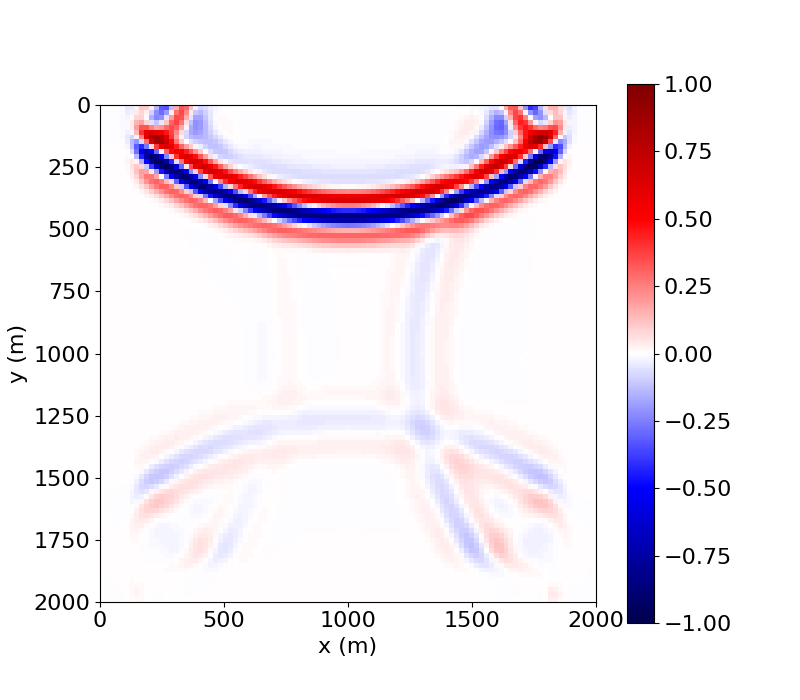

In [31]:
scale = np.abs(p.data[1]).max()
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(p.data[1].T/scale,
               origin="upper",
               vmin=-1, vmax=1,
               extent=[0, grid.extent[0], grid.extent[1], 0],
               cmap='seismic')
fig.colorbar(im, ax=ax)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.show()

As we can see, the wave is effectively damped at the edge of the domain by the 10 layers of PMLs, with diminished reflections back into the domain.

## **QC Task:** "Inject" Impulses into $p(x,y)$, $v_x(x,y)$, and $v_y(x,y)$ Fields

We will place impulses at the center, and at each corner execatly the "half-with" of the spatial sentcil away from the edges.

* We can look at the **extent** of the stencils to verify or check our boundaries and `SubDomain`s
* The first plt we will see will only have the **center stencil**, not the corners. Do you know **why**?  

#### Zero Data Fields

In [32]:
v[0].data.fill(0)
v[1].data.fill(0)
p.data.fill(0)

#### Set Impulses

In [33]:
v[0].data[0,ix,iy] = 1.0
v[1].data[0,ix,iy] = 1.0 
p.data[0, ix, iy]  = 1.0  

#### Run Operator

In [34]:
op = Operator([eq_v, eq_p])
op(time=1)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.2e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

#### Mask Impulses *(I think staggered grid results in some very small outputs near stencils)*

In [35]:
plt_stencil_data = np.abs(p.data[1])    
mask = plt_stencil_data <= 1e-4
plt_stencil_data[mask] = 0
plt_stencil_data[~mask] = 1

#### Plot Impulse Reponses

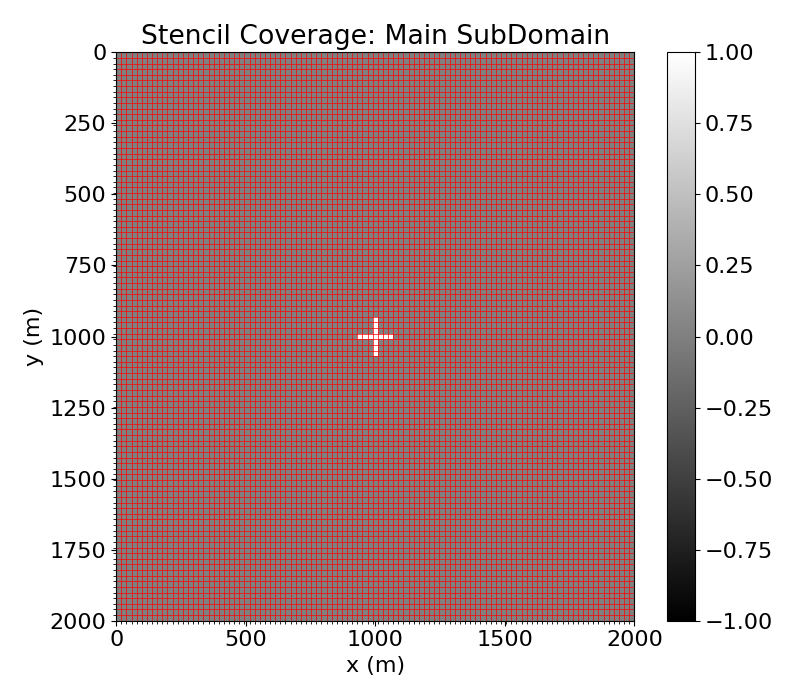

In [36]:
vmax = np.abs(plt_stencil_data).max()

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(plt_stencil_data.T,
               origin="upper",
               vmin=-vmax, vmax=vmax,
               extent=[0, grid.extent[0], grid.extent[1], 0],
               cmap='gray',
               aspect='auto',
               interpolation='nearest')
fig.colorbar(im, ax=ax)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

# add grid lines between elements 
nx, ny = plt_stencil_data.shape
x_edges = np.linspace(0, grid.extent[0], nx + 1)
y_edges = np.linspace(0, grid.extent[1], ny + 1)
ax.set_xticks(x_edges, minor=True)
ax.set_yticks(y_edges, minor=True)
ax.grid(which='minor', color='r', linestyle='-', linewidth=0.5)
ax.set_title("Stencil Coverage: Main SubDomain")

plt.tight_layout()
plt.show()

## **QC Task:** *Fix* the Impulse Response from $p(x,y)$, $v_x(x,y)$, and $v_y(x,y)$ Fields

The equations ran by the `Operator` imediately above were assigned `SubDomain`s which do not cover the impulses near the cornders.

#### Zero Data Fields

In [37]:
v[0].data.fill(0)
v[1].data.fill(0)
p.data.fill(0)

#### Set Impulses

In [38]:
v[0].data[0,ix,iy] = 1.0
v[1].data[0,ix,iy] = 1.0 
p.data[0, ix, iy]  = 1.0  

#### **Either Assigned to the Full `Subdomain` or Make New Equations Assigned to the Full Subdomain**

In [39]:
do_reassign = True  # If true, just reassign, else create new equations

if do_reassign:
    eq_v.subdomain = grid
    eq_p.subdomain = grid

else:
    eq_v_full = Eq(v.forward, v - dt*grad(p)/density,
            subdomain=grid) # <-- look!

    eq_p_full = Eq(p.forward, p - dt*velocity**2*density*div(v.forward),
               subdomain=grid) # <-- look!

#### Run Operator

In [40]:
if do_reassign:
    op = Operator([eq_v, eq_p])

else:
    op = Operator([eq_v_full, eq_p_full])
    # look! -------------^  and  ----^

op(time=1)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.7e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

#### Mask Impulses *(I think staggered grid results in some very small outputs near stencils)*

In [41]:
plt_stencil_data = np.abs(p.data[1])    
mask = plt_stencil_data <= 1e-4
plt_stencil_data[mask] = 0
plt_stencil_data[~mask] = 1

#### Plot Impulse Reponses (All Should Show)

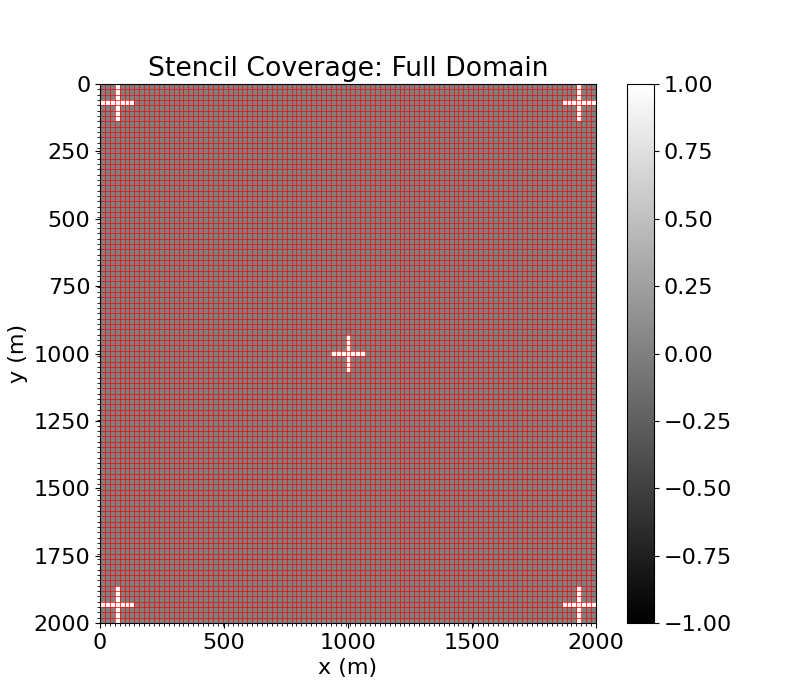

In [42]:
vmax = np.abs(plt_stencil_data).max()

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(plt_stencil_data.T,
               origin="upper",
               vmin=-vmax, vmax=vmax,
               extent=[0, grid.extent[0], grid.extent[1], 0],
               cmap='gray',
               aspect='auto',
               interpolation='nearest')
fig.colorbar(im, ax=ax)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

# add grid lines between elements 
nx, ny = plt_stencil_data.shape
x_edges = np.linspace(0, grid.extent[0], nx + 1)
y_edges = np.linspace(0, grid.extent[1], ny + 1)
ax.set_xticks(x_edges, minor=True)
ax.set_yticks(y_edges, minor=True)
ax.grid(which='minor', color='r', linestyle='-', linewidth=0.5)
ax.set_title("Stencil Coverage: Full Domain")

plt.tight_layout
plt.show()